In [370]:
import json
import numpy as np
import matplotlib.pyplot as plt
from utils.udp_util import extract_udp_prague_to_dataframe
from utils.plotter import  plot_siftr_graph

In [371]:
# File paths

file_cubic = '../data/udp_net_2025-06-06-14-07-14/iperf3_client_cubic_iperf3_d120.json'
file_udp = '../data/udp_net_2025-06-06-14-07-14/udp_prague_receiver_iperf3_d120.json'

duration = 1800  # Duration in seconds

file_udp = '../data/udp_net_2025-06-10-13-27-49/udp_prague_receiver_iperf3_d1800.json'
file_cubic = '../data/udp_net_2025-06-10-13-27-49/iperf3_client_cubic_iperf3_d1800.json'

utf = extract_udp_prague_to_dataframe(file_udp)

from utils.util import create_directory_if_not_exists
import os
graph_directory = os.path.join("./", "Graphs")
create_directory_if_not_exists(graph_directory)


Directory already exists: ./Graphs


In [372]:
utf[65:70]

,Time,Rcvd_Mbps,Sent_Mbps,RTT_ms,Mark_pct,Mark_Marked,Mark_Total,Lost_pct,Lost_Lost,Lost_Total
65,65.07,36.988,0.581,7.436,0.06,2,3303,0.15,5,3303
66,66.07,62.020,0.975,7.150,1.23,68,5538,0.00,0,5538
67,67.07,69.793,1.097,7.133,1.57,98,6232,0.00,0,6232
68,68.07,71.721,1.127,7.120,1.37,88,6405,0.00,0,6405
69,69.07,79.353,1.247,6.925,1.26,89,7086,0.00,0,7086


In [373]:
import json
import numpy as np
import pandas as pd

def extract_data_df(filename):
    with open(filename) as f:
        data = json.load(f)

    records = []

    for interval in data['intervals']:
        record = {
            'time': interval['sum']['start'],
            'bitrate_mbps': interval['sum']['bits_per_second'] / 1_000_000
        }

        stream = interval['streams'][0]
        if 'rtt' in stream:
            record['rtt_time'] = stream['start']
            record['rtt_ms'] = stream['rtt'] / 1000.0  # µs to ms
        else:
            record['rtt_time'] = None
            record['rtt_ms'] = None

        records.append(record)

    df = pd.DataFrame(records)
    return df


In [374]:
import json
import pandas as pd

def extract_data_df(filename):
    with open(filename) as f:
        data = json.load(f)

    records = []

    for interval in data['intervals']:
        record = {
            'time': interval['sum']['start'],
            'bitrate_mbps': interval['sum']['bits_per_second'] / 1_000_000
        }

        stream = interval['streams'][0]

        # RTT
        if 'rtt' in stream:
            record['rtt_time'] = stream['start']
            record['rtt_ms'] = stream['rtt'] / 1000.0  # µs to ms
        else:
            record['rtt_time'] = None
            record['rtt_ms'] = None

        # Retransmits
        record['retransmits'] = stream.get('retransmits', None)

        # Send congestion window (bytes to KB)
        if 'snd_cwnd' in stream:
            record['snd_cwnd_kb'] = stream['snd_cwnd'] / 1024.0
        else:
            record['snd_cwnd_kb'] = None

        records.append(record)

    df = pd.DataFrame(records)
    return df


In [375]:



# Function to extract data from iperf3 JSON
def extract_data(filename):
    with open(filename) as f:
        data = json.load(f)

    times = []
    bitrates = []
    rtt_times = []
    rtts = []

    for interval in data['intervals']:
        times.append(interval['sum']['start'])
        bitrates.append(interval['sum']['bits_per_second'] / 1_000_000)  # Convert to Mbit/s

        stream = interval['streams'][0]
        if 'rtt' in stream:
            rtt_times.append(stream['start'])
            rtts.append(stream['rtt'] / 1000.0)  # µs to ms

    return np.array(times), np.array(bitrates), np.array(rtt_times), np.array(rtts)





import os
os.path.exists(file_cubic)

# Extract data
t_cubic, b_cubic, rt_cubic, rtt_cubic = extract_data(file_cubic)

In [376]:
tfcubic = extract_data_df(file_cubic)

In [377]:
tfcubic.describe()

,time,bitrate_mbps,rtt_time,rtt_ms,retransmits,snd_cwnd_kb
count,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000
mean,899.500198,145.403471,899.500198,13.876996,0.487778,241.924883
std,519.759595,42.953235,519.759595,5.233135,7.494884,84.595316
min,0.000000,0.000000,0.000000,1.124000,0.000000,1.414062
25%,449.750115,134.882405,449.750115,10.655000,0.000000,193.726562
50%,899.500106,159.499958,899.500106,13.062000,0.000000,246.046875
75%,1349.250098,170.462479,1349.250098,16.014250,0.000000,295.539062
max,1799.000096,230.689951,1799.000096,84.670000,257.000000,526.031250


In [378]:
baseline_throuhgput_df = pd.read_csv('../router_configsv1.csv')

# Add 'Time' column starting from 0, increasing by 30 seconds
baseline_throuhgput_df['Time'] = [i * 30 for i in range(len(baseline_throuhgput_df))]


# Set Time as index and reindex to include every second from 0 to 120
baseline_throuhgput_df.set_index('Time', inplace=True)
# baseline_throuhgput_df = baseline_throuhgput_df.reindex(range(0, 121))  # Reindex from 0 to 120
baseline_throuhgput_df.ffill(inplace=True)  # Forward-fill the missing values

# Reset index so Time is a column again
baseline_throuhgput_df = baseline_throuhgput_df.reset_index().rename(columns={'index': 'Time'})

print(baseline_throuhgput_df)

    Time  thrpt  latency  ber_qpsk  loss_pct
0      0    184        6  0.117095        12
1     30    239        6  0.078310         8
2     60    189        6  0.112921        11
3     90    430        6  0.012877         1
4    120    336        6  0.034279         3
..   ...    ...      ...       ...       ...
56  1680    139        8  0.159525        16
57  1710    149        7  0.148882        15
58  1740    222        8  0.088952         9
59  1770    232        7  0.082738         8
60  1800    267        6  0.062667         6

[61 rows x 5 columns]


In [379]:
baseline_propagation_delay_df = pd.read_csv('../router_configsv1.csv')

# Add 'Time' column starting from 0, increasing by 30 seconds
baseline_propagation_delay_df['Time'] = [i * 30 for i in range(len(baseline_propagation_delay_df))]
baseline_propagation_delay_df.rename(columns={'latency': 'SmoothedRTT'}, inplace=True)

print(baseline_propagation_delay_df)

    thrpt  SmoothedRTT  ber_qpsk  loss_pct  Time
0     184            6  0.117095        12     0
1     239            6  0.078310         8    30
2     189            6  0.112921        11    60
3     430            6  0.012877         1    90
4     336            6  0.034279         3   120
..    ...          ...       ...       ...   ...
56    139            8  0.159525        16  1680
57    149            7  0.148882        15  1710
58    222            8  0.088952         9  1740
59    232            7  0.082738         8  1770
60    267            6  0.062667         6  1800

[61 rows x 5 columns]


In [380]:
utf.rename(columns={'RTT_ms': 'SmoothedRTT'}, inplace=True)
tfcubic.rename(columns={'rtt_ms': 'SmoothedRTT'}, inplace=True)


utf.rename(columns={'time': 'Time'}, inplace=True)
tfcubic.rename(columns={'time': 'Time'}, inplace=True)


utf.rename(columns={'Rcvd_Mbps': 'thrpt'}, inplace=True)
tfcubic.rename(columns={'bitrate_mbps': 'thrpt'}, inplace=True)


utf.rename(columns={'Lost_Lost': 'Lost_Packets'}, inplace=True)
tfcubic.rename(columns={'retransmits': 'Lost_Packets'}, inplace=True)

In [381]:
utf

,Time,thrpt,Sent_Mbps,SmoothedRTT,Mark_pct,Mark_Marked,Mark_Total,Lost_pct,Lost_Packets,Lost_Total
0,0.00,0.000,0.000,0.000,0.00,0,1,0.00,0,1
1,1.05,0.039,0.001,6.722,0.00,0,5,0.00,0,5
2,2.05,11.354,0.178,6.925,0.49,5,1014,0.00,0,1014
3,3.05,26.768,0.421,7.067,0.54,13,2391,0.00,0,2391
4,4.05,38.256,0.601,7.090,2.31,79,3416,0.00,0,3416
...,...,...,...,...,...,...,...,...,...,...
1805,1837.35,159.285,2.503,6.978,0.00,0,14222,0.01,1,14222
1806,1838.35,240.073,3.773,7.719,0.50,107,21438,0.15,32,21438
1807,1839.35,223.738,3.516,7.313,0.00,0,19981,0.04,8,19981
1808,1840.35,145.071,2.280,7.111,0.00,0,12955,0.10,13,12955


In [382]:
tfcubic

,Time,thrpt,rtt_time,SmoothedRTT,Lost_Packets,snd_cwnd_kb
0,0.000000,176.350528,0.000000,12.205,0,231.906250
1,1.000090,150.128944,1.000090,16.733,0,285.640625
2,2.000088,135.009766,2.000088,18.713,0,328.062500
3,3.000101,127.192828,3.000101,15.680,0,264.429688
4,4.000097,116.766483,4.000097,19.532,0,302.609375
...,...,...,...,...,...,...
1795,1795.000224,167.790782,1795.000224,9.196,0,238.976562
1796,1796.000113,167.762761,1796.000113,9.297,0,229.078125
1797,1797.000169,178.262372,1797.000169,11.688,0,292.710938
1798,1798.000144,188.752737,1798.000144,11.955,0,267.257812


In [383]:
utf

,Time,thrpt,Sent_Mbps,SmoothedRTT,Mark_pct,Mark_Marked,Mark_Total,Lost_pct,Lost_Packets,Lost_Total
0,0.00,0.000,0.000,0.000,0.00,0,1,0.00,0,1
1,1.05,0.039,0.001,6.722,0.00,0,5,0.00,0,5
2,2.05,11.354,0.178,6.925,0.49,5,1014,0.00,0,1014
3,3.05,26.768,0.421,7.067,0.54,13,2391,0.00,0,2391
4,4.05,38.256,0.601,7.090,2.31,79,3416,0.00,0,3416
...,...,...,...,...,...,...,...,...,...,...
1805,1837.35,159.285,2.503,6.978,0.00,0,14222,0.01,1,14222
1806,1838.35,240.073,3.773,7.719,0.50,107,21438,0.15,32,21438
1807,1839.35,223.738,3.516,7.313,0.00,0,19981,0.04,8,19981
1808,1840.35,145.071,2.280,7.111,0.00,0,12955,0.10,13,12955


In [384]:
(utf['SmoothedRTT'] > 50).value_counts()

SmoothedRTT
False    1809
True        1
Name: count, dtype: int64

In [385]:
# Calculate the median of the 'SmoothedRTT' column
median_rtt = utf['SmoothedRTT'].median()

# Replace outliers (values greater than 50) with the median
utf['SmoothedRTT'] = utf['SmoothedRTT'].apply(lambda x: median_rtt if x > 50 else x)

In [386]:
paths = {
    "Cubic": tfcubic,
    "UDP-Prague": utf,
    "Baseline Propagation Delay": baseline_propagation_delay_df
}

utf.to_csv("./graph_data/udp_prague_rtt.csv")
tfcubic.to_csv("./graph_data/cubic_rtt.csv")
baseline_propagation_delay_df.to_csv("./graph_data/baseline_propagation_delay_df.csv")

In [387]:
# Ensure 'Time' is int in all dataframes
baseline_propagation_delay_df['Time'] = baseline_propagation_delay_df['Time'].astype(int)
utf['Time'] = utf['Time'].astype(int)
tfcubic['Time'] = tfcubic['Time'].astype(int)

# Merge utf with baseline to compare SmoothedRTT
utf_merged = pd.merge(utf, baseline_propagation_delay_df, on='Time', suffixes=('_utf', '_baseline'))

# Filter utf where SmoothedRTT is greater than baseline
utf_filtered_rtt = utf_merged[utf_merged['SmoothedRTT_utf'] > utf_merged['SmoothedRTT_baseline']]

# Keep only utf columns
utf_filtered_rtt = utf_filtered_rtt[['Time', 'SmoothedRTT_utf']].rename(columns={'SmoothedRTT_utf': 'SmoothedRTT'})

# Similarly for tfcubic
tfcubic_merged = pd.merge(tfcubic, baseline_propagation_delay_df, on='Time', suffixes=('_tfcubic', '_baseline'))
tfcubic_filtered_rtt = tfcubic_merged[tfcubic_merged['SmoothedRTT_tfcubic'] > tfcubic_merged['SmoothedRTT_baseline']]
tfcubic_filtered_rtt = tfcubic_filtered_rtt[['Time', 'SmoothedRTT_tfcubic']].rename(columns={'SmoothedRTT_tfcubic': 'SmoothedRTT'})

# Results:
# utf_filtered_rtt and tfcubic_filtered_rtt only contain rows where RTT is greater than baseline at each Time



In [388]:
baseline_throuhgput_df = baseline_throuhgput_df[baseline_throuhgput_df['Time'] <= 1800]

baseline_propagation_delay_df = baseline_propagation_delay_df[baseline_propagation_delay_df['Time'] <= 1800]

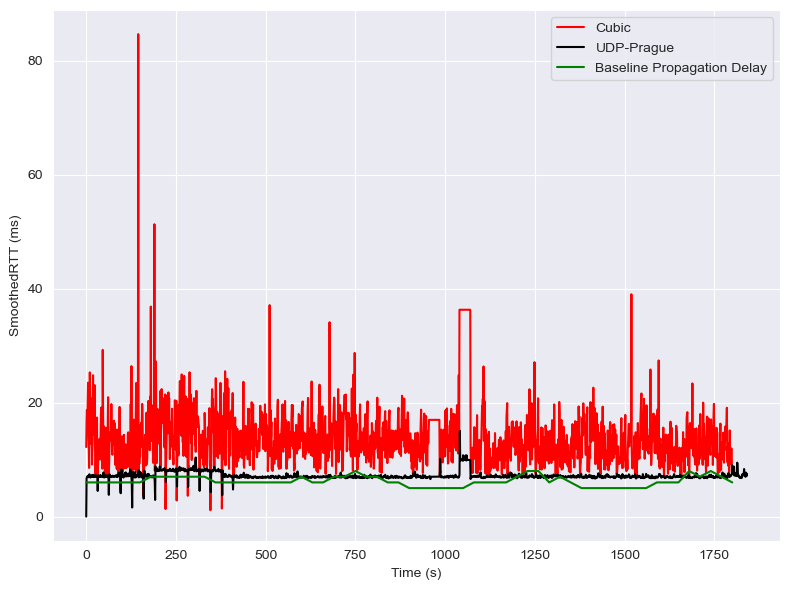

In [389]:
    # Define paths
paths = {
    "Cubic": tfcubic,
    "UDP-Prague": utf,
    "Baseline Propagation Delay": baseline_propagation_delay_df
}


# paths = {
#     "Cubic": tfcubic_filtered_rtt,
#     "UDP-Prague": utf_filtered_rtt,
#     "Baseline Propagation Delay": baseline_propagation_delay_df
# }


scenario = str("RTT_UDPPraguevsCubic")

plot_siftr_graph(paths=paths,
                ycolumn="SmoothedRTT",
                title=f"{scenario} SmoothedRTT",
                xlabel="Time (s)",
                ylabel="SmoothedRTT (ms)",
                filename=f'{scenario}',
                graph_directory=graph_directory,
)

In [390]:
tfcubic['thrpt']

0       176.350528
1       150.128944
2       135.009766
3       127.192828
4       116.766483
           ...    
1795    167.790782
1796    167.762761
1797    178.262372
1798    188.752737
1799    157.235922
Name: thrpt, Length: 1800, dtype: float64

In [391]:
utf['thrpt']

0         0.000
1         0.039
2        11.354
3        26.768
4        38.256
         ...   
1805    159.285
1806    240.073
1807    223.738
1808    145.071
1809    201.493
Name: thrpt, Length: 1810, dtype: float64

In [392]:
tfcubic['Time'] = tfcubic['Time'].astype(int)

In [393]:
tfcubic['Time']

0          0
1          1
2          2
3          3
4          4
        ... 
1795    1795
1796    1796
1797    1797
1798    1798
1799    1799
Name: Time, Length: 1800, dtype: int32

In [394]:
utf['Time'] = utf['Time'].astype(int)

In [395]:
# tfcubic.set_index('Time', inplace=True)
# utf.set_index('Time', inplace=True)
# baseline_throuhgput_df.set_index('Time', inplace=True)

In [396]:

# Step 1: Forward fill existing NaNs
baseline_throuhgput_df = baseline_throuhgput_df.set_index('Time')

baseline_throuhgput_df.ffill(inplace=True)

# Step 2: Reindex to include every second
# Create new full second index range from min to max
full_index = pd.RangeIndex(start=baseline_throuhgput_df.index.min(),
                           stop=baseline_throuhgput_df.index.max() + 1,  # +1 to include last second
                           step=1)

# Step 3: Reindex and forward fill new rows
baseline_throuhgput_df = baseline_throuhgput_df.reindex(full_index).ffill()
baseline_throuhgput_df = baseline_throuhgput_df.reindex(baseline_throuhgput_df.index.astype(int))
baseline_throuhgput_df = baseline_throuhgput_df.reset_index().rename(columns={'index': 'Time'})


In [397]:
import pandas as pd

# Example dfs: baseline_throuhgput_df, utf, tfcubic

# Ensure 'Time' is int in all dataframes (optional step)
baseline_throuhgput_df['Time'] = baseline_throuhgput_df['Time'].astype(int)
utf['Time'] = utf['Time'].astype(int)
tfcubic['Time'] = tfcubic['Time'].astype(int)

# Merge utf with baseline on 'Time' to compare throughput
utf_merged = pd.merge(utf, baseline_throuhgput_df, on='Time', suffixes=('_utf', '_baseline'))

# Filter utf rows where utf throughput < baseline throughput
utf_filtered = utf_merged[utf_merged['thrpt_utf'] < utf_merged['thrpt_baseline']]

# Keep only original utf columns
utf_filtered = utf_filtered[['Time', 'thrpt_utf']].rename(columns={'thrpt_utf': 'thrpt'})

# Same for tfcubic
tfcubic_merged = pd.merge(tfcubic, baseline_throuhgput_df, on='Time', suffixes=('_tfcubic', '_baseline'))
tfcubic_filtered = tfcubic_merged[tfcubic_merged['thrpt_tfcubic'] < tfcubic_merged['thrpt_baseline']]
tfcubic_filtered = tfcubic_filtered[['Time', 'thrpt_tfcubic']].rename(columns={'thrpt_tfcubic': 'thrpt'})

# Now utf_filtered and tfcubic_filtered are filtered dataframes where throughput is lower than baseline at each Time

# Results:
# utf_filtered
# tfcubic_filtered


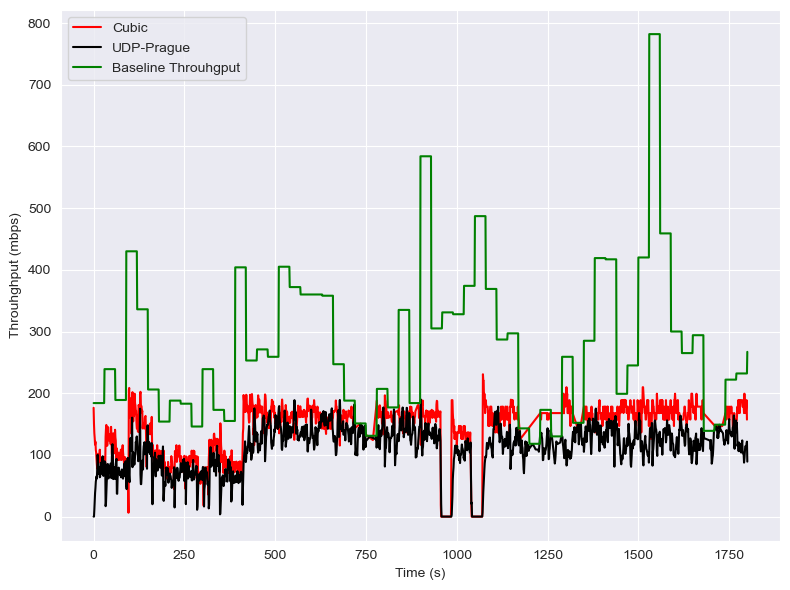

In [398]:
    # Define paths
paths = {
    "Cubic": tfcubic,
    "UDP-Prague": utf,
    "Baseline Throuhgput": baseline_throuhgput_df
}


paths = {
    "Cubic": tfcubic_filtered,
    "UDP-Prague": utf_filtered,
    "Baseline Throuhgput": baseline_throuhgput_df
}



scenario = str("Thrpt_UDPPraguevsCubic")

plot_siftr_graph(paths=paths,
                ycolumn="thrpt",
                title=f"{scenario} Throuhghput",
                xlabel="Time (s)",
                ylabel="Throuhghput (mbps)",
                filename=f'{scenario}',
                graph_directory=graph_directory,
)

In [399]:
baseline_throuhgput_df

,Time,thrpt,latency,ber_qpsk,loss_pct
0,0,184.0,6.0,0.117095,12.0
1,1,184.0,6.0,0.117095,12.0
2,2,184.0,6.0,0.117095,12.0
3,3,184.0,6.0,0.117095,12.0
4,4,184.0,6.0,0.117095,12.0
...,...,...,...,...,...
1796,1796,232.0,7.0,0.082738,8.0
1797,1797,232.0,7.0,0.082738,8.0
1798,1798,232.0,7.0,0.082738,8.0
1799,1799,232.0,7.0,0.082738,8.0


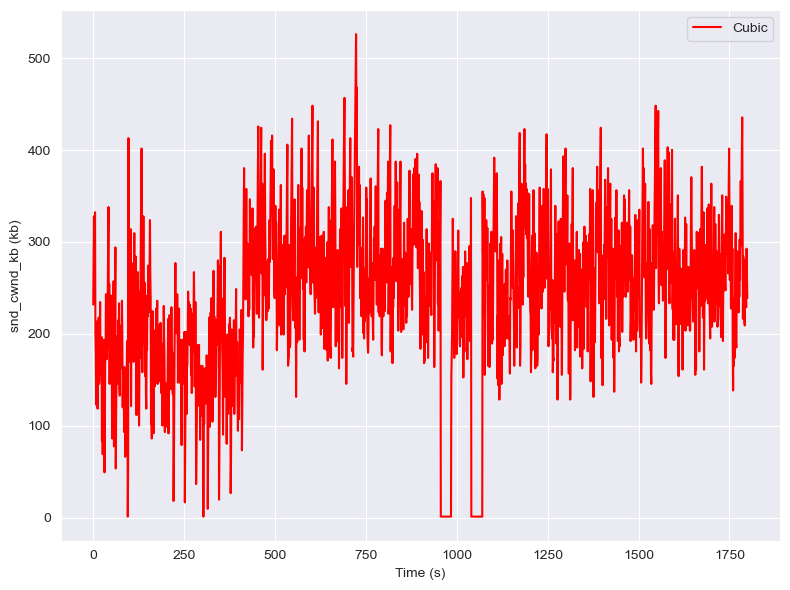

In [400]:
    # Define paths
paths = {
    "Cubic": tfcubic,
    # "UDP-Prague": utf,
    # "Baseline Throuhgput": baseline_throuhgput_df
}



scenario = str("snd_cwnd_UDPPraguevsCubic")

plot_siftr_graph(paths=paths,
                ycolumn="snd_cwnd_kb",
                title=f"{scenario} snd_cwnd_kb",
                xlabel="Time (s)",
                ylabel="snd_cwnd_kb (kb)",
                filename=f'{scenario}',
                graph_directory=graph_directory,
)

In [401]:
tfcubic[['Time', 'Lost_Packets']].to_csv("./graph_data/cubic_loss.csv", index=False)
utf[['Time', 'Lost_Packets']].to_csv("./graph_data/udp_prague_loss.csv", index=False)


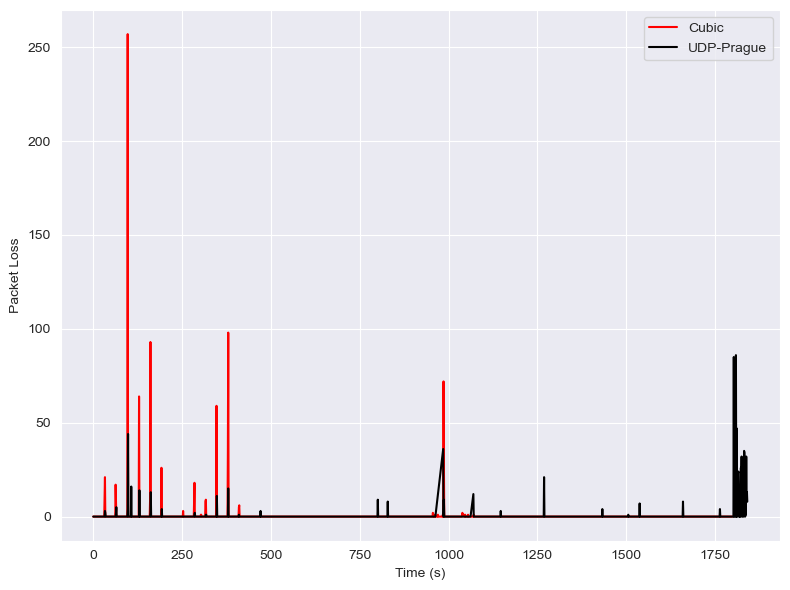

In [402]:
    # Define paths
paths = {
    "Cubic": tfcubic,
    "UDP-Prague": utf,
    # "Baseline Throuhgput": baseline_throuhgput_df
}



scenario = str("PktLoss_UDPPraguevsCubic")

plot_siftr_graph(paths=paths,
                ycolumn="Lost_Packets",
                title=f"{scenario} Packet Loss",
                xlabel="Time (s)",
                ylabel="Packet Loss",
                filename=f'{scenario}',
                graph_directory=graph_directory,
)

In [403]:

utf.rename(columns={'Lost_Packets': 'Loss'}, inplace=True)
tfcubic.rename(columns={'Lost_Packets': 'Loss'}, inplace=True)

In [404]:
tfcubic[['Time', 'Loss']].to_csv("./graph_data/cubic_loss.csv", index=False)
utf[['Time', 'Loss']].to_csv("./graph_data/udp_prague_loss.csv", index=False)


In [405]:
tfcubic[['Time', 'Loss']].to_csv("./graph_data/cubic_loss.csv", index=False)
utf[['Time', 'Loss']].to_csv("./graph_data/udp_prague_loss.csv", index=False)


In [406]:
utf.rename(columns={'thrpt': 'Throughput (Mbit/s)'}, inplace=True)
tfcubic.rename(columns={'thrpt': 'Throughput (Mbit/s)'}, inplace=True)
baseline_throuhgput_df.rename(columns={'thrpt': 'Throughput (Mbit/s)'}, inplace=True)

In [407]:
tfcubic[['Time', 'Throughput (Mbit/s)']].to_csv("./graph_data/cubic_thrpt.csv", index=False)
utf[['Time', 'Throughput (Mbit/s)']].to_csv("./graph_data/udp_prague_thrpt.csv", index=False)
baseline_throuhgput_df[['Time', 'Throughput (Mbit/s)']].to_csv("./graph_data/baseline_thrpt.csv", index=False)


In [408]:
#     # Define paths
# paths = {
#     # "Cubic": tfcubic,
#     "UDP-Prague": utf,
#     # "Baseline Throuhgput": baseline_throuhgput_df
# }



# scenario = str("Thrpt_UDPPraguevsCubic")

# plot_siftr_graph(paths=paths,
#                 ycolumn="Lost_Lost",
#                 title=f"{scenario} Lost_Lost",
#                 xlabel="Time (s)",
#                 ylabel="Lost_Lost",
#                 filename=f'{scenario}',
#                 graph_directory=graph_directory,
# )

In [409]:
#     # Define paths
# paths = {
#     "Cubic": tfcubic,
#     # "UDP-Prague": utf,
#     # "Baseline Throuhgput": baseline_throuhgput_df
# }



# scenario = str("Thrpt_UDPPraguevsCubic")

# plot_siftr_graph(paths=paths,
#                 ycolumn="retransmits",
#                 title=f"{scenario} retransmits",
#                 xlabel="Time (s)",
#                 ylabel="retransmits",
#                 filename=f'{scenario}',
#                 graph_directory=graph_directory,
# )